# Food Classification (Part 1)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!ls drive/MyDrive/2Image-Classification/outputs/
DATA_PATH = "drive/MyDrive/2Image-Classification/outputs/"

best_model.pth	Model1.pth  Model3.pth	Model6.pth  oldModel2.pth
Model0.pth	Model2.pth  Model5.pth	Model9.pth  oldModel3.pth


# Get Data and CSVs

Download and get all the data images and files from the AI Crowd portal.

In [3]:
!pip install aicrowd-cli -q

     |████████████████████████████████| 51kB 2.8MB/s 
     |████████████████████████████████| 61kB 4.6MB/s 
     |████████████████████████████████| 163kB 12.3MB/s 
     |████████████████████████████████| 61kB 6.5MB/s 
     |████████████████████████████████| 204kB 11.6MB/s 
     |████████████████████████████████| 81kB 7.6MB/s 
     |████████████████████████████████| 71kB 7.3MB/s 
     |████████████████████████████████| 51kB 5.5MB/s 
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.


In [4]:
API_KEY = "c0377f0fb65414eaa12c1998de4c65c2" #Please enter your API Key from [https://www.aicrowd.com/participants/me]
!aicrowd login --api-key $API_KEY

API Key valid
Saved API Key successfully!


In [5]:
!aicrowd dataset download --challenge chunin-exams-food-track-cv-2021

train_images.zip: 100% 754M/754M [00:38<00:00, 19.7MB/s]
test_images.zip: 100% 33.9M/33.9M [00:02<00:00, 13.2MB/s]
train.csv: 100% 253k/253k [00:00<00:00, 489kB/s]
test.csv: 100% 7.27k/7.27k [00:00<00:00, 749kB/s]


In [6]:
!unzip -q train_images.zip

In [7]:
!unzip -q test_images.zip

# Imports

In [1]:
import matplotlib.pyplot as plt
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
import tqdm
import cv2
from PIL import Image

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.utils.data.sampler import SubsetRandomSampler
from torch import nn, optim
from torchvision import transforms, utils, datasets

# Dataset Creation and Loader

In order use our training and test data for deep learning, it needs to be in a compatible format. All deep learning frameworks and libraries require the data in a specific format, in order to process it and train corresponding models. For this purpose, the ***Dataloader*** and ***Dataset Class*** are important methods. These help us to feed our own training data into the network. 

The Dataset class is used to provide an interface for accessing all the training or testing samples in the dataset. That is, it creates a class with methods in order to reference the different instances of the data samples. A custom data set class in python overrides the `__getitem__` and the `__len__` methods, so as to suite the requirements of the custom data format. 

Although we can access all the training data using the Dataset class, for deep learning, we would need *batching, shuffling, multiprocess data loading*, etc. DataLoader class helps us to do this. The DataLoader class accepts a dataset and other parameters such as `batch_size`, `batch_sampler` and `number of workers` to load the data .Then we can iterate over the Dataloader to get batches of training data and train our models.

**References**:

* To build a custom dataset and dataloader : [Reference](https://pytorch.org/tutorials/recipes/recipes/custom_dataset_transforms_loader.html)

* Writing a Python Dataloader : [Reference](https://medium.com/analytics-vidhya/writing-a-custom-dataloader-for-a-simple-neural-network-in-pytorch-a310bea680af)

In [9]:
food_id2name = {}
food_name2id = {}

food_i = -1
with open("dataset_info.txt", 'r') as f:

    line = f.readline().strip()

    while(line):
        if food_i < 0 :
            food_i+=1
            line = f.readline().strip()
            continue

        num, name = line.split(" ")
        num = int(num[:-1])
        food_id2name[num] = name
        food_name2id[name] = num

        food_i+=1
        line = f.readline().strip()

In [10]:
len(food_name2id)

62

In [11]:
class FoodDataset(Dataset):

    def __init__(self, csv_file, root_dir, dataset_type, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.food_df = pd.read_csv(csv_file)
        #self.food_df = self.food_df.head(100)
        
        if dataset_type == "train":
           self.food_df = self.food_df.groupby('ClassName').apply(lambda x: x.sample(frac=0.40)).reset_index(drop = True) #selecting a subset of data (61*70)

        self.root_dir = root_dir
        self.transform = transform
        self.dataset_type = dataset_type

    def __len__(self):
        return len(self.food_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir, self.food_df.iloc[idx, 0])
        image = Image.open(img_name)
        image = image.resize((64,64))

        if self.dataset_type == "train":
            food_class = torch.tensor(food_name2id[self.food_df.iloc[idx, 1]])
            sample = {'image': image, 'food_class': food_class}
        else:
            sample = {'image': image}

        if self.transform:
            sample["image"] = self.transform(sample["image"])

        return sample


# Data Transformations

Many a times during training, the train data may not be fully representative of all the possibilities of input to the machine learning model. Especially for images, there could exist different orientations, angles, colours, intensities of the same image, thus causing differences in the input. Not all of these variations will be present in the dataset. Therefore, a suite of transformations used at training time is typically referred to as **data augmentation** and is a common practice for modern model development.

It performs the set of transformations *on fly* in each iteration. Hence it does not increase the actual scale of the data on the disk.

There exist multiple types of data augmentation techniques that can be applied to the train dataset images :

* Rotation, Horizontal and Vertical Flip, Affine transforms
* Colour Jitter variation transofrms
* Normalization to a particular $(\mu, \sigma)$ distribution
* Conversion to tensor transforms.

**Note :** 

The ToTensor converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]. This is required to convert all images to tensors in our dataloader. [Ref](https://towardsdatascience.com/pytorch-vision-binary-image-classification-d9a227705cf9)

References : 
* Survey paper on how augmentation helps : [Link](https://scholar.smu.edu/cgi/viewcontent.cgi?article=1091&context=datasciencereview)

In [12]:
image_transforms1 = {
    "train": transforms.Compose([
        transforms.RandomRotation(30),
        #transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        #transforms.RandomAffine(0, shear=10, scale = (0.8, 1.2)),
        #transforms.ColorJitter(brightness=0.2, contrast = 0.2, saturation =0.2),
        #transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ]),
    "test": transforms.Compose([
        #transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Resize(255),
        transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
}

In [13]:
image_transforms2 = {
    "train": transforms.Compose([
        #transforms.Resize((256, 256)),
        transforms.ToTensor()
    ]),
    "test": transforms.Compose([
        #transforms.Resize((256, 256)),
        transforms.ToTensor()
    ])
}

In [14]:
food_train_dataset = FoodDataset(csv_file=os.path.join("train.csv"), 
                                 root_dir=os.path.join("train_images"), 
                                 dataset_type="train",
                                 transform = image_transforms1["train"]
                                 )

In [15]:
food_test_dataset = FoodDataset(csv_file=os.path.join("test.csv"), 
                                root_dir=os.path.join("test_images"), 
                                dataset_type="test",
                                 transform = image_transforms1["test"]
                                )

# Analyzing the Train and Test Data

To begin with, it's a good practice to get an overview of the data that is present. In this problem statement, the task is a ***classification task***. Therefore, it is good to see the distribution of classes in the train dataset, and whether there exists a bias/skewed distribution in the data. 

Here, there are `9323` train samples and `484` test data images. The normalized $64 * 64$ images of the first 8 train samples are shown below, to get an idea of how the train data looks like. 

Further, a normalized histogram of the number of occurences of each class is also plotted. We see that there does exist a skew in the distribution, as the samples of class `water` , `bread-white` are much higher than the classes `pickle`, `onion` etc.

In [16]:
print("Total train samples =", len(food_train_dataset))
print("Total test samples =", len(food_test_dataset))

Total train samples = 3726
Total test samples = 484


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


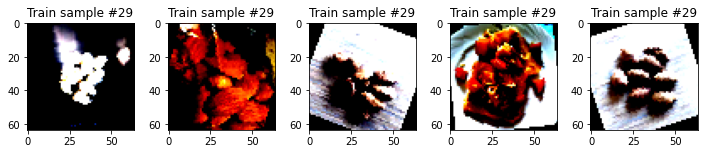

In [17]:
fig = plt.figure(figsize = (10,10))

for i in range(0, 5):
    sample = food_train_dataset[i]
    ax = plt.subplot(1, 5, i + 1)
    plt.tight_layout()
    ax.set_title('Train sample #{}'.format(sample['food_class']))
    #ax.axis('off')
    ax.imshow(sample["image"].permute(1, 2, 0))   #EACH IMAGE IS OF THE SHAPE = (C x H x W)

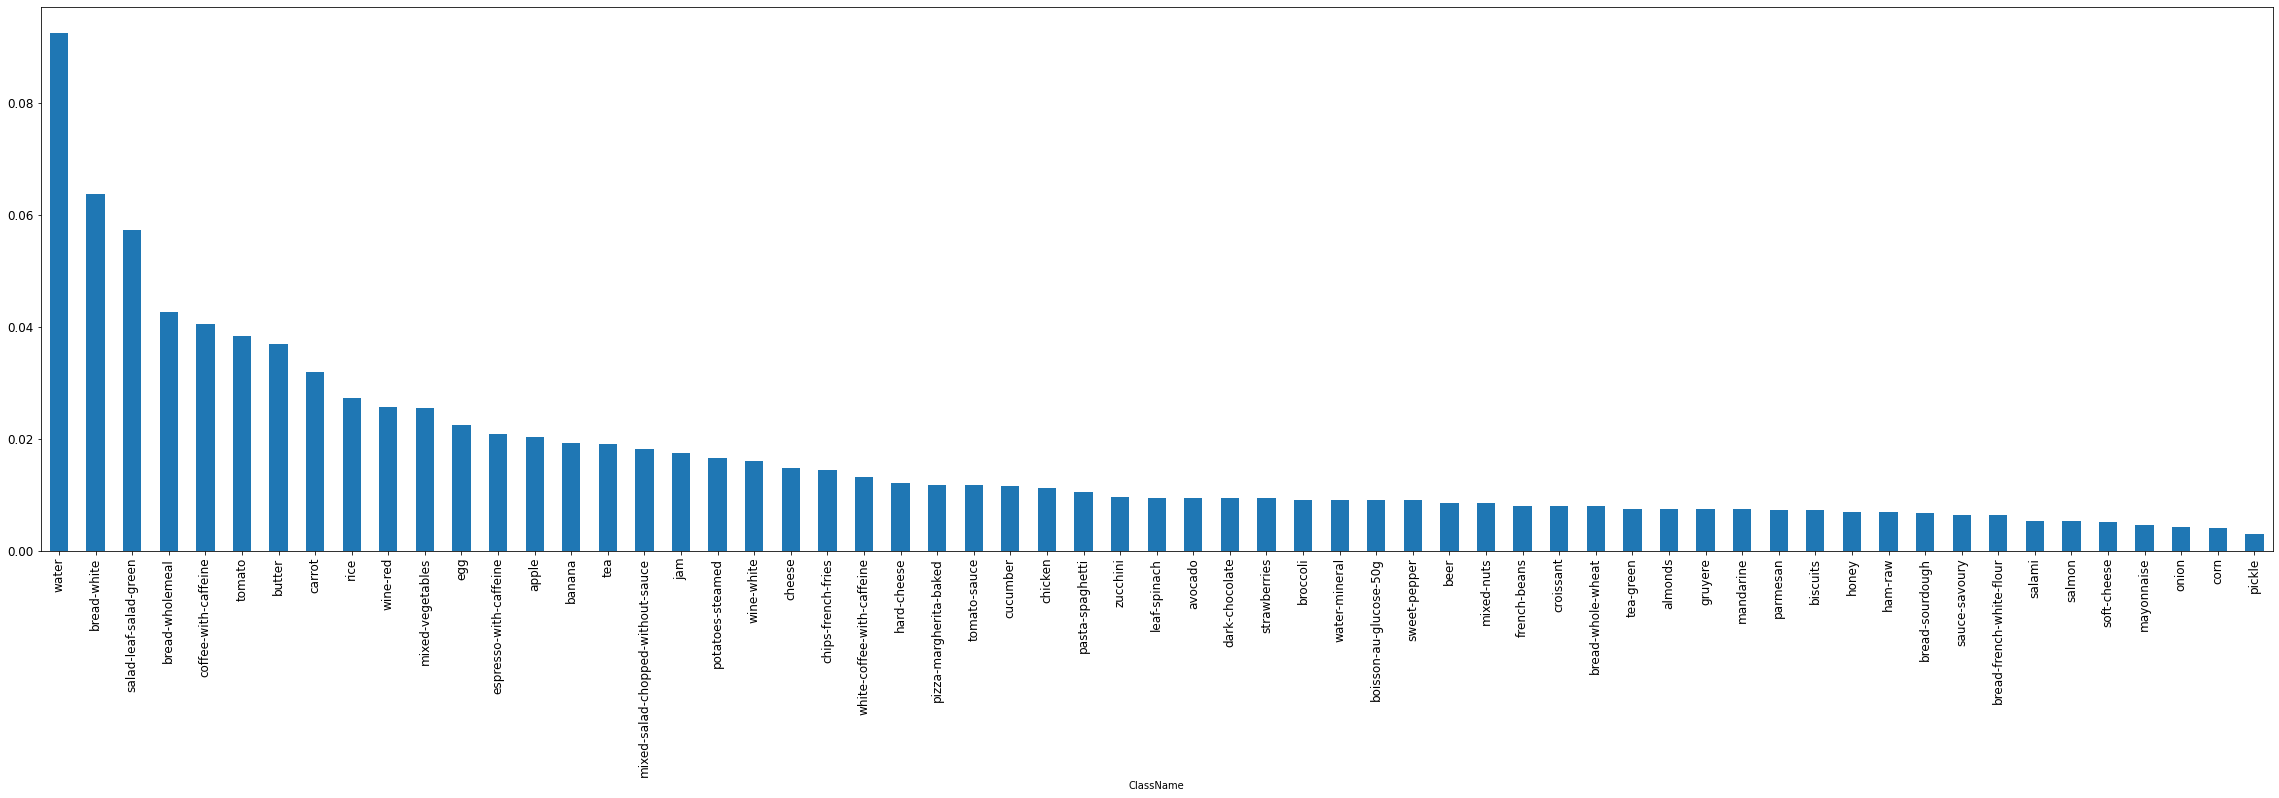

In [18]:
food_train_dataset.food_df.value_counts("ClassName", normalize=True).plot(x="ClassName", y="count", kind="bar", fontsize=12, figsize=(40,10))

In [19]:
#create the train validation and test dataloaders

BATCH_SIZE = 128
VAL_SPLIT = 0.2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(food_train_dataset)
indices = list(range(len(food_train_dataset)))
split = int(np.floor(VAL_SPLIT * dataset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
val_sampler = SubsetRandomSampler(val_indices)

In [20]:
train_dataloader = DataLoader(food_train_dataset, batch_size=BATCH_SIZE, num_workers=4, sampler=train_sampler)
val_dataloader = DataLoader(food_train_dataset, batch_size=BATCH_SIZE, num_workers=4, sampler=val_sampler)
test_dataloader = DataLoader(food_test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [21]:
print("Total train batches =", len(train_dataloader))
print("Total validation batches =", len(val_dataloader))
print("Total test batches =", len(test_dataloader))

Total train batches = 24
Total validation batches = 6
Total test batches = 4


# Build Image Classifier : Model Architechture


For the model architechture, a convolutional neural network based architechture was used. The model was experimented with different hyper parameters and the results for each are noted below. 

For the classification task of classifying these food images into one out of the 61 classes, the ***SGD optimizer*** was chosen with a learnign rate of ```0.007```, momentum of ```0.95``` and a weight decay of ```1e-5```. For the loss function, the ```CrossEntropyLoss``` was used and the output of the classifier was decided using the ```softmax``` non-linearity. 

In this architechture, the CNN layers follow the arrangement of : ```CNN > Pool > BatchNorm > Activation > Dropout```
Since the max pooling and the non-linearities/activations commute, therefore, they can be applied in an interchangeable order. [[Ref]](https://stackoverflow.com/questions/35543428/activation-function-after-pooling-layer-or-convolutional-layer)



References:
* 2 conv layers : [Link](https://www.analyticsvidhya.com/blog/2019/10/building-image-classification-models-cnn-pytorch/)
* More complex architechture : [Link](https://thevatsalsaglani.medium.com/training-and-deploying-a-multi-label-image-classifier-using-pytorch-flask-reactjs-and-firebase-c39c96f9c427)
* [CNN Ref](https://towardsdatascience.com/a-beginners-guide-to-convolutional-neural-networks-cnns-14649dbddce8)
* [Digit Classifier](https://towardsdatascience.com/convolutional-neural-network-for-image-classification-with-implementation-on-python-using-pytorch-7b88342c9ca9)
* [CNN2 Ref](https://medium.com/analytics-vidhya/image-classification-with-convolutional-neural-networks-ac14a978f0fa)
* [Binary Class CNN](https://github.com/Haylemicheal/Cats-vs-Dogs-Classifier/blob/master/Cats%20vs%20Dogs%20classifier.ipynb)

In [22]:
# defining the model architecture
class FoodClassifier(nn.Module):   
    def __init__(self):
        super(FoodClassifier, self).__init__()

        '''
        Architechture option 1
        '''
        # self.cnn_layers = nn.Sequential(
        #     # Defining a 2D convolution layer
        #     nn.Conv2d(3, 4, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(4),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        #     # Defining another 2D convolution layer
        #     nn.Conv2d(4, 4, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm2d(4),
        #     nn.ReLU(inplace=True),
        #     nn.MaxPool2d(kernel_size=2, stride=2),
        # )

        # self.linear_layers = nn.Sequential(
        #     nn.Linear(4 * 64 * 64, 62)
        #)

        '''
        Architechture option 2
        '''
        self.ConvLayer1 = nn.Sequential(nn.Conv2d(3, 32, 3, stride=1, padding=1), 
                                        nn.MaxPool2d(2),
                                        #nn.LPPool2d(2,2), 
                                        #nn.BatchNorm2d(32),
                                        nn.ReLU(), 
                                        nn.Dropout(0.3)
                                        )
        self.ConvLayer2 = nn.Sequential(nn.Conv2d(32, 64, 3, stride=1, padding=1),
                                        nn.MaxPool2d(2), 
                                        #nn.LPPool2d(2,2),
                                        #nn.BatchNorm2d(64),
                                        nn.ReLU(),
                                        nn.Dropout(0.3)
                                        )
        self.ConvLayer3 = nn.Sequential(nn.Conv2d(64, 128, 3, stride=1, padding=1), 
                                        nn.MaxPool2d(2), 
                                        #nn.LPPool2d(2,2),
                                        #nn.BatchNorm2d(128),
                                        nn.ReLU(), 
                                        nn.Dropout(0.3)
                                        )
        self.ConvLayer4 = nn.Sequential(nn.Conv2d(128, 256, 3, stride=1, padding=1),
                                        nn.MaxPool2d(2), 
                                        #nn.LPPool2d(2,2),
                                        #nn.BatchNorm2d(256),
                                        nn.ReLU(), 
                                        nn.Dropout(0.3)
                                        )
        
        self.ConvLayer5 = nn.Sequential(nn.Conv2d(256, 512, 3, stride=1, padding=1),
                                        nn.MaxPool2d(2), 
                                        #nn.LPPool2d(2,2),
                                        #nn.BatchNorm2d(512),
                                        nn.ReLU(), 
                                        nn.Dropout(0.3)
                                        )
        
        self.LinearLayers = nn.Sequential(nn.Linear(512 * 2*2, 1024),
                                          nn.Linear(1024, 512),
                                          nn.Linear(512, 256),
                                          nn.Linear(256, 62),
                                          #nn.Linear(512, 62),
                                          #nn.LogSoftmax(dim=1)
                                        )


    # Defining the forward pass    
    def forward(self, x):
        '''
        Forward pass option 1 
        '''
        # x = self.cnn_layers(x)
        # x = x.view(x.size(0), -1)
        # x = self.linear_layers(x)
        # return x

        '''
        Forward pass option 2
        '''
        #print("ori x ", x.shape)
        x = self.ConvLayer1(x)
        #print("layer 1", x.shape)
        x = self.ConvLayer2(x)
        #print("layer 2", x.shape)
        x = self.ConvLayer3(x)
        #print("layer 3", x.shape)
        x = self.ConvLayer4(x)
        #print("layer 4", x.shape)
        x = self.ConvLayer5(x)
        #print("layer 5", x.shape)
        x = x.view(x.size(0), -1)
        x = self.LinearLayers(x)
        return x

In [23]:
# checking if GPU is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


# defining the model, optimizer, loss func
model = FoodClassifier().to(device)
# optimizer = optim.Adam(model.parameters(), lr=0.007)
# optimizer = optim.SGD(model.parameters(), lr = 0.0001, momentum = 0.9, weight_decay = 5e-5)
optimizer = optim.SGD(model.parameters(), lr = 0.007, momentum = 0.95, weight_decay = 1e-5)

#loss_fn = nn.NLLLoss().to(device) #negative log likelihood loss function is better as it can capture the softmax layer
loss_fn = nn.CrossEntropyLoss().to(device)

'''
nn.CrossEntropyLoss expects integer labels. What it does internally is that it doesn't end up one-hot encoding 
the class label at all, but uses the label to index into the output probability vector to calculate the loss 
should you decide to use this class as the final label. This small but important detail makes computing the loss 
easier and is the equivalent operation to performing one-hot encoding, measuring the output loss per output neuron 
as every value in the output layer would be zero with the exception of the neuron indexed at the target class. 
Therefore, there's no need to one-hot encode your data if you have the labels already provided.
'''

print(device)
print(model)

cuda:0
FoodClassifier(
  (ConvLayer1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (ConvLayer2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (ConvLayer3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
  (ConvLayer4): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=Fa

# Training the Model on Train Dataset

In [24]:
EPOCHS = 50

In [ ]:
train_losses = []
val_losses = []
val_loss_min = np.Inf

for epoch in tqdm.tqdm(range(EPOCHS)):

    train_loss = 0
    val_loss = 0

    #trainign on the train dataset
    model.train()
    for batch in (train_dataloader):
        
        images = batch["image"]
        labels = batch["food_class"]

        if torch.cuda.is_available():
            images = images.to(device)
            labels = labels.to(device)

        # Training pass
        optimizer.zero_grad()
        output = model(images)
        #_, predicted = torch.max(torch.exp(output.data), 1)

        #print("out ", output.shape, "lab ", labels.shape, "pred", predicted.shape)
        #print(output)
        #print(predicted)
        #print(labels)

        loss = loss_fn(output, labels)

        #print(loss.item(),"loss")
        #print(images.size(0), "sizes")
        #print("loss term = ", loss.item()*images.size(0))

        #print(torch.exp(output[0]))
        #print(output.data[0])
        #print(output[0])

        #This is where the model learns by backpropagating
        loss.backward()

        #And optimizes its weights here
        optimizer.step()
        train_loss += loss.item()*images.size(0)
        '''
        because the loss given by CrossEntropy or other loss functions is 
        divided by the number of elements i.e. the reduction parameter is mean by default.
        '''

    #evaluating on the validation dataset
    model.eval()
    with torch.no_grad():
        for batch in (val_dataloader):
            
            images = batch["image"]
            labels = batch["food_class"]

            if torch.cuda.is_available():
                images = images.to(device)
                labels = labels.to(device)

            output = model(images)
            loss = loss_fn(output, labels)
            val_loss += loss.item()*images.size(0)

    train_loss = train_loss/len(train_dataloader.sampler)
    val_loss = val_loss/len(val_dataloader.sampler)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))
    
    if val_loss <= val_loss_min:
        print("Validation Loss decreased {:0.6f} -> {:0.6f}".format(val_loss_min,val_loss))
        val_loss_min = val_loss
        torch.save(model.state_dict(), os.path.join(DATA_PATH , 'best_model.pth'))
    #print()
    #print("Epoch {} - Training loss: {}".format(i+1, running_loss/len(train_dataloader)))

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch: 0 	Training Loss: 4.068678 	Validation Loss: 4.001070
Validation Loss decreased inf -> 4.001070


  4%|▍         | 2/50 [00:54<21:41, 27.10s/it]

Epoch: 1 	Training Loss: 3.850668 	Validation Loss: 3.906051
Validation Loss decreased 4.001070 -> 3.906051


  6%|▌         | 3/50 [01:21<21:04, 26.91s/it]

Epoch: 2 	Training Loss: 3.800769 	Validation Loss: 3.889673
Validation Loss decreased 3.906051 -> 3.889673


  8%|▊         | 4/50 [01:47<20:33, 26.81s/it]

Epoch: 3 	Training Loss: 3.790681 	Validation Loss: 3.895962


 10%|█         | 5/50 [02:14<20:00, 26.68s/it]

Epoch: 4 	Training Loss: 3.781772 	Validation Loss: 3.898541


 12%|█▏        | 6/50 [02:40<19:35, 26.71s/it]

Epoch: 5 	Training Loss: 3.777383 	Validation Loss: 3.893712


 14%|█▍        | 7/50 [03:07<19:11, 26.77s/it]

Epoch: 6 	Training Loss: 3.776137 	Validation Loss: 3.881700
Validation Loss decreased 3.889673 -> 3.881700


 16%|█▌        | 8/50 [03:34<18:48, 26.86s/it]

Epoch: 7 	Training Loss: 3.766905 	Validation Loss: 3.873371
Validation Loss decreased 3.881700 -> 3.873371


 18%|█▊        | 9/50 [04:01<18:19, 26.83s/it]

Epoch: 8 	Training Loss: 3.756387 	Validation Loss: 3.849538
Validation Loss decreased 3.873371 -> 3.849538


 20%|██        | 10/50 [04:28<17:55, 26.89s/it]

Epoch: 9 	Training Loss: 3.742014 	Validation Loss: 3.849487
Validation Loss decreased 3.849538 -> 3.849487


 22%|██▏       | 11/50 [04:55<17:26, 26.82s/it]

Epoch: 10 	Training Loss: 3.727936 	Validation Loss: 3.811517
Validation Loss decreased 3.849487 -> 3.811517


 24%|██▍       | 12/50 [05:22<16:58, 26.80s/it]

Epoch: 11 	Training Loss: 3.703359 	Validation Loss: 3.789500
Validation Loss decreased 3.811517 -> 3.789500


 26%|██▌       | 13/50 [05:48<16:29, 26.75s/it]

Epoch: 12 	Training Loss: 3.661501 	Validation Loss: 3.723548
Validation Loss decreased 3.789500 -> 3.723548


 28%|██▊       | 14/50 [06:15<16:01, 26.72s/it]

Epoch: 13 	Training Loss: 3.559103 	Validation Loss: 3.625774
Validation Loss decreased 3.723548 -> 3.625774


 30%|███       | 15/50 [06:42<15:37, 26.80s/it]

Epoch: 14 	Training Loss: 3.485201 	Validation Loss: 3.571400
Validation Loss decreased 3.625774 -> 3.571400


 32%|███▏      | 16/50 [07:09<15:11, 26.82s/it]

Epoch: 15 	Training Loss: 3.405142 	Validation Loss: 3.496828
Validation Loss decreased 3.571400 -> 3.496828


 34%|███▍      | 17/50 [07:35<14:43, 26.78s/it]

Epoch: 16 	Training Loss: 3.355492 	Validation Loss: 3.460856
Validation Loss decreased 3.496828 -> 3.460856


 36%|███▌      | 18/50 [08:02<14:19, 26.86s/it]

Epoch: 17 	Training Loss: 3.313044 	Validation Loss: 3.432184
Validation Loss decreased 3.460856 -> 3.432184


 38%|███▊      | 19/50 [08:29<13:52, 26.86s/it]

Epoch: 18 	Training Loss: 3.302297 	Validation Loss: 3.498917


 40%|████      | 20/50 [08:56<13:26, 26.90s/it]

Epoch: 19 	Training Loss: 3.300555 	Validation Loss: 3.403292
Validation Loss decreased 3.432184 -> 3.403292


 42%|████▏     | 21/50 [09:23<12:58, 26.86s/it]

Epoch: 20 	Training Loss: 3.293251 	Validation Loss: 3.428301


 44%|████▍     | 22/50 [09:50<12:31, 26.85s/it]

Epoch: 21 	Training Loss: 3.267803 	Validation Loss: 3.408002


 46%|████▌     | 23/50 [10:17<12:08, 26.96s/it]

Epoch: 22 	Training Loss: 3.263500 	Validation Loss: 3.386812
Validation Loss decreased 3.403292 -> 3.386812


 48%|████▊     | 24/50 [10:44<11:42, 27.01s/it]

Epoch: 23 	Training Loss: 3.225140 	Validation Loss: 3.371709
Validation Loss decreased 3.386812 -> 3.371709


 50%|█████     | 25/50 [11:12<11:18, 27.13s/it]

Epoch: 24 	Training Loss: 3.199994 	Validation Loss: 3.324267
Validation Loss decreased 3.371709 -> 3.324267


 52%|█████▏    | 26/50 [11:39<10:49, 27.08s/it]

Epoch: 25 	Training Loss: 3.225750 	Validation Loss: 3.346155


 54%|█████▍    | 27/50 [12:06<10:25, 27.19s/it]

Epoch: 26 	Training Loss: 3.221611 	Validation Loss: 3.378502


 56%|█████▌    | 28/50 [12:33<09:57, 27.17s/it]

Epoch: 27 	Training Loss: 3.181564 	Validation Loss: 3.390127


 58%|█████▊    | 29/50 [13:00<09:29, 27.12s/it]

Epoch: 28 	Training Loss: 3.165837 	Validation Loss: 3.285823
Validation Loss decreased 3.324267 -> 3.285823


 60%|██████    | 30/50 [13:27<09:01, 27.10s/it]

Epoch: 29 	Training Loss: 3.138036 	Validation Loss: 3.290580


 62%|██████▏   | 31/50 [13:54<08:35, 27.11s/it]

Epoch: 30 	Training Loss: 3.093691 	Validation Loss: 3.235719
Validation Loss decreased 3.285823 -> 3.235719


 64%|██████▍   | 32/50 [14:21<08:06, 27.05s/it]

Epoch: 31 	Training Loss: 3.049239 	Validation Loss: 3.241016


 66%|██████▌   | 33/50 [14:48<07:39, 27.03s/it]

Epoch: 32 	Training Loss: 3.033079 	Validation Loss: 3.202566
Validation Loss decreased 3.235719 -> 3.202566


 68%|██████▊   | 34/50 [15:15<07:12, 27.05s/it]

Epoch: 33 	Training Loss: 3.050487 	Validation Loss: 3.269139


 70%|███████   | 35/50 [15:42<06:45, 27.04s/it]

Epoch: 34 	Training Loss: 3.000022 	Validation Loss: 3.165038
Validation Loss decreased 3.202566 -> 3.165038


 72%|███████▏  | 36/50 [16:10<06:19, 27.07s/it]

Epoch: 35 	Training Loss: 3.004814 	Validation Loss: 3.254885


 74%|███████▍  | 37/50 [16:37<05:52, 27.09s/it]

Epoch: 36 	Training Loss: 2.964728 	Validation Loss: 3.121039
Validation Loss decreased 3.165038 -> 3.121039


 76%|███████▌  | 38/50 [17:04<05:24, 27.04s/it]

Epoch: 37 	Training Loss: 2.975860 	Validation Loss: 3.161856


 78%|███████▊  | 39/50 [17:30<04:56, 26.98s/it]

Epoch: 38 	Training Loss: 2.928621 	Validation Loss: 3.139967


 80%|████████  | 40/50 [17:57<04:29, 26.97s/it]

Epoch: 39 	Training Loss: 2.883814 	Validation Loss: 3.088470
Validation Loss decreased 3.121039 -> 3.088470


 82%|████████▏ | 41/50 [18:24<04:02, 26.91s/it]

Epoch: 40 	Training Loss: 2.853579 	Validation Loss: 3.139678


 84%|████████▍ | 42/50 [18:51<03:35, 26.89s/it]

Epoch: 41 	Training Loss: 2.863008 	Validation Loss: 3.013699
Validation Loss decreased 3.088470 -> 3.013699


 86%|████████▌ | 43/50 [19:18<03:08, 26.94s/it]

Epoch: 42 	Training Loss: 2.819278 	Validation Loss: 3.050200


 88%|████████▊ | 44/50 [19:45<02:41, 26.90s/it]

Epoch: 43 	Training Loss: 2.783170 	Validation Loss: 3.151755


 90%|█████████ | 45/50 [20:12<02:14, 26.84s/it]

Epoch: 44 	Training Loss: 2.736220 	Validation Loss: 3.016377


 92%|█████████▏| 46/50 [20:38<01:47, 26.87s/it]

Epoch: 45 	Training Loss: 2.752192 	Validation Loss: 2.983394
Validation Loss decreased 3.013699 -> 2.983394


 94%|█████████▍| 47/50 [21:05<01:20, 26.88s/it]

Epoch: 46 	Training Loss: 2.737959 	Validation Loss: 3.041764


 96%|█████████▌| 48/50 [21:32<00:53, 26.84s/it]

Epoch: 47 	Training Loss: 2.691392 	Validation Loss: 2.958551
Validation Loss decreased 2.983394 -> 2.958551


 98%|█████████▊| 49/50 [21:59<00:26, 26.86s/it]

Epoch: 48 	Training Loss: 2.685598 	Validation Loss: 2.927234
Validation Loss decreased 2.958551 -> 2.927234


100%|██████████| 50/50 [22:26<00:00, 26.93s/it]

Epoch: 49 	Training Loss: 2.662605 	Validation Loss: 2.990697


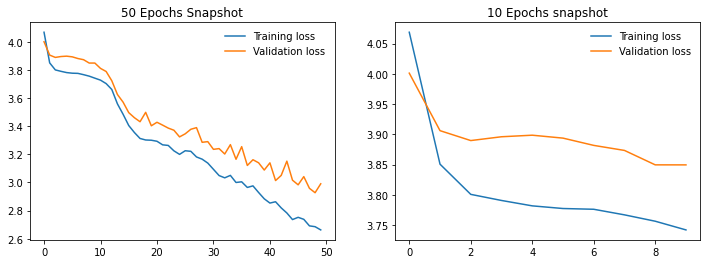

In [ ]:
fig, ax = plt.subplots(1,2, figsize = (12,4))

ax[0].plot(train_losses, label='Training loss')
ax[0].plot(val_losses, label='Validation loss')
ax[0].legend(frameon=False)
ax[0].set_title("50 Epochs Snapshot")

ax[1].plot(train_losses[:10], label='Training loss')
ax[1].plot(val_losses[:10], label='Validation loss')
ax[1].legend(frameon=False)
ax[1].set_title("10 Epochs snapshot")

plt.savefig("loss_plot.png")

In [36]:
model.load_state_dict(torch.load(os.path.join(DATA_PATH, 'Model3.pth')))
model.eval()

correct = 0
total = 0
preds = []
ground_truths = []

with torch.no_grad():
    for batch in (val_dataloader):
        images = batch['image'].to(device)
        labels = batch['food_class'].to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        
        preds += [pr for pr in predicted.detach().cpu().numpy()]                
        ground_truths += [ truth for truth in labels.detach().cpu().numpy()]
        
        correct += (predicted == labels).sum().item()

print('Accuracy of the network = ', (100 * correct / total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:477: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the network =  28.187919463087248


## Plotting Conf matrix

In [37]:
from sklearn.metrics import confusion_matrix
import sklearn.metrics
import seaborn as sns

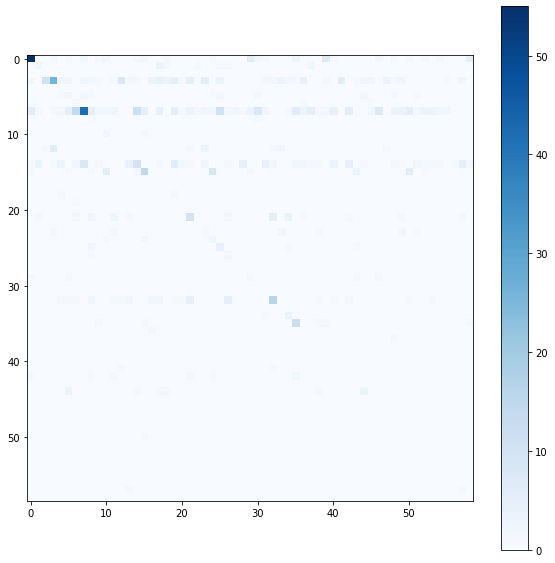

In [38]:
cm = sklearn.metrics.confusion_matrix(preds, ground_truths)

fig = plt.figure(figsize = (10,10))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.colorbar()

In [1]:
def readim(path):
    
    im = cv2.imread(path)
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    return im

# ------------------------------------------------------
# Final Observations and Results : 
# ------------------------------------------------------


There are multiple hyperparameters that are associated with this model and classification task. Each of the hyperparameters was fine-tuned and experimented with, keeping the other parameters constant. Their effect on the accuracy, recall, runtime, and overall performance for the classification task was noted down. 

Targe size of the train-dataset is considerably large : ```9323``` train images split as train and validation data. Unlike the robust pretrained models of densenet, resnet etc. this model is a relatively shallow architechture that was built from scratch for these experiments. Hence in order to reduce the runtime, a *subsample* of the training data ```3726``` train samples were used. 

All the results mentioned in this analysis are based on this subsampled dataset only. However, for a few experiments, the full dataset was also used. 

A detailed analysis of the effect of each of the hyperparameters is mentioned in the following parts of the notebook.


## ------------------------------------------------------
## <mark>1) Batch Norm                           </mark>
## ------------------------------------------------------


Normalization is a pre-processing technique used to standardize data. It improves the learning speed of Neural Networks and provides regularization, avoiding overfitting. Batch Norm is a normalization technique done between the layers of a Neural Network instead of in the raw data. It is done along mini-batches instead of the full data set. It serves to speed up training and use higher learning rates, making learning easier. <sup>[[1]](https://www.baeldung.com/cs/batch-normalization-cnn)</sup>

> This experiment was done using both the *full set* of data as well as the *random subsample* of the training data.

There are primarily **2 observations** made with the ```BatchNorm``` hyperparameter : 

1. For the full dataset, we observe that with the batch norm, we achieve a higher accuracy as compared to the one without batch norm.

2. For shallow networks, BatchNorm effects are not that prominet. It is more **beneficial for deep neural networks (DNN)**. In a shallow Network, BNorm introduces an additional computational load plus some extra parameters. <sup>[[1]](https://www.quora.com/Have-you-ever-observed-that-batch-normalization-actually-slows-the-training-down)</sup> <sup>[[2]](https://discuss.pytorch.org/t/slow-training-and-validation-loss-doesnt-decrease/57687/3)</sup>

The accuracies obtained are as follows : 

| BatchNorm |      Data   | Val Acc |
|:----------------:|:-----------------:|:---------:|
| No |  Full Data | 30.8476 |
| Yes |  Full Data | **33.4764** |
| No |  Subset Data | **27.9194** |
| Yes |  Subset Data | 25.9060 |


The graphs for the train-validation loss as well as the confusion matrices of the experiments are as follows : 

### Train- Validation Loss Plots

| WITHOUT Batch Norm (Full data) |      WITH Batch Norm (Full data)   |
|:----------------:|:-----------------:|
| ![](../graphs/old/fullset/model0-tr-val.png) |  ![](../graphs/old/fullset/model1-tr-val.png) |



| WITHOUT Batch Norm (Subsample data)   |      WITH Batch Norm (Subsample data)     |
|:----------------|:-----------------:|
| ![](../graphs/colab-graphs/subset/model0-tv.png) |  ![](../graphs/colab-graphs/subset/model1-tv.png) |


### Confusion Matrices

| WITHOUT Batch Norm (Subsample)  |      WITH Batch Norm (Subsample)     |
|:----------------|:-----------------:|
| <img src="../graphs/colab-graphs/subset/model0-cm.png" alt="Drawing" style="width: 350px;"/> |  <img src="../graphs/colab-graphs/subset/model1-cm.png" alt="Drawing" style="width: 350px;"/> |

## ------------------------------------------------------
## <mark>2) CNN and Linear Layers                          </mark>
## ------------------------------------------------------

Deeper CNNs perform better that shallow ones. This is primarily because, they are able to extract more number of high level features at the early layers, and the low level information is captured at the later layers. Therefore, a lot of information about the image is obtained via deeper layers. A deeper model will convolve more the input data thereby extracting relevant feature (mostly the edges, shapes, colors, etc). This allows the network to perform more convolutions and lets it extract with more precision the features it “judges” relevant according to the dataset. <sup>[[1]](https://medium.com/finc-engineering/cnn-do-we-need-to-go-deeper-afe1041e263e)</sup>

> This experiment was done using both the *full set* of data as well as the *random subsample* of the training data.

In this architechture experiment, two experiments were done :
1. ***Model a)***: With 3 CNN Layers and 3 Linear Layers
2. ***Model b)*** With 5 CNN Layers and 4 Linear Layers

The accuracies obtained are as follows : 

| Model |      Data   | Val Acc |
|:----------------:|:-----------------:|:---------:|
| Model a) |  Full Data | 30.8476 |
| Model b) |  Full Data | **33.9056** |
| Model a) |  Subsample Data | 27.5168 |
| Model b) |  Subsample Data | **28.0537** |



The graphs for the train-validation loss as well as the confusion matrices of the experiments are as follows : 

### Train- Validation Loss Plots

From the train and validation loss plots as well as the accuracies obtained above, we can clearly observe that having more layers definitely improves the performance of the CNN and classification model. Further, it **prevents overfitting** of the model as shown in the loss plot, as the validation loss also continues to decrease with increase in the number of epochs indicating that the model training is not overfitting. The advantage of multiple layers is that they can learn features at various levels of abstraction.



| Model a) Full Data |      Model b) Full Data  |
|:----------------:|:-----------------:|
| ![](../graphs/old/fullset/model0-tr-val.png) |  ![](../graphs/old/fullset/model2-tr-val.png) |



| Model a) Subsample |      Model b) Subsample  |
|:----------------|:-----------------:|
| ![](../graphs/colab-graphs/subset/model0-tv.png) |  ![](../graphs/colab-graphs/subset/model2-tv.png) |


### Confusion Matrices

| Model a) |      Model b)   |
|:----------------|:-----------------:|
| <img src="../graphs/colab-graphs/subset/model0-cm.png" alt="Drawing" style="width: 350px;"/> |  <img src="../graphs/colab-graphs/subset/model2-cm.png" alt="Drawing" style="width: 350px;"/> |

## ------------------------------------------------------
## <mark>3) Dropout                         </mark>
## ------------------------------------------------------

Dropout is a regularization method that approximates training a large number of neural networks with different architectures in parallel. During training, some number of layer outputs are randomly ignored or “dropped out.” This has the effect of making the layer look-like and be treated-like a layer with a different number of nodes and connectivity to the prior layer. In effect, each update to a layer during training is performed with a different “view” of the configured layer.<sup>[[1]](https://machinelearningmastery.com/dropout-for-regularizing-deep-neural-networks/)</sup>

Drop out helps prevent overfitting and acts as a good regularizer term.

> This experiment was done using both the *full set* of data as well as the *random subsample* of the training data.

In this architechture experiment, two experiments were done :
1. ***Model a)***: Dropout = None, 5 CNN Layers and 4 Linear Layers
2. ***Model b)***: Dropout = 0.3,  5 CNN Layers and 4 Linear Layers

The accuracies obtained are as follows : 

| Model |      Data   | Val Acc |
|:----------------:|:-----------------:|:---------:|
| Model a) |  Full Data | 33.9056 |
| Model b) |  Full Data | **34.3348** |
| Model a) |  Subsample Data | **28.0537** |
| Model b) |  Subsample Data | 26.8456 |



| Model a) Full Data |      Model b) Full Data  |
|:----------------:|:-----------------:|
| ![](../graphs/old/fullset/model2-tr-val.png) |  ![](../graphs/old/fullset/model3-tr-val.png) |



| Model a) Subsample |      Model b)  Subsample |
|:----------------|:-----------------:|
| ![](../graphs/colab-graphs/subset/model2-tv.png) |  ![](../graphs/colab-graphs/subset/model3-tv.png) |


### Confusion Matrices

| Model a) |      Model b)   |
|:----------------|:-----------------:|
| <img src="../graphs/colab-graphs/subset/model0-cm.png" alt="Drawing" style="width: 350px;"/> |  <img src="../graphs/colab-graphs/subset/model3-cm.png" alt="Drawing" style="width: 350px;"/> |

## ------------------------------------------------------
## <mark>4) Activation Functions                        </mark>
## ------------------------------------------------------

The most common activation function used with CNNs is the ```ReLU```. In the experiments that were conducted, there were 3 activation functions that were tried :  ```ReLU```, ```Tanh``` and ```Sigmoid```. The best results were obtained using ReLU while the lowest accuracy was with Sigmoid. For each of these activation functions, the same number of CN and Linear Layers were used - 5 CNN and 4 Linear layers. Further, we observe that the performance of ReLU and TanH was relatively similar

The accuracies obtained are as follows : 

| Activation |      Data   | Val Acc |
|:----------------:|:-----------------:|:---------:|
| Sigmoid |  Subsample Data | 8.9933 |
| Tanh |  Subsample Data | 26.7798 |
| ReLU |  Subsample Data | **26.8457** |

```ReLU``` is the best suited for classification purposes as in this case. It avoids and rectifies the vanishing gradient problem. It's uses commonly along with CNNs and it has the power to converge the model quickly as well. 

```Sigmoid``` is an activation function whose range is located between 0 and 1, and it generally works better when we have to predict the probability as an output in logistic regression scenarios to determine the probability of classes occurrence. <sup>[[1]](https://datascience.aero/aviation-function-deep-learning/)</sup>

On the other hand, the ```Tanh``` function has a main advantage that that the negative inputs will be mapped strongly negative and the zero inputs will be mapped near zero. The ```Tanh function``` is mainly used in scenarios where we want to perform a classification between two classes. <sup>[[1]](https://datascience.aero/aviation-function-deep-learning/)</sup>




|ReLU |      Tanh   | Sigmoid | 
|:----------------|:-----------------:|:-----------------:|
| ![](../graphs/colab-graphs/subset/model2-tv.png) |  ![](../graphs/colab-graphs/subset/model5-tv.png) |  ![](../graphs/colab-graphs/subset/model6-tv.png) |


### Confusion Matrices

|ReLU |      Tanh   | Sigmoid | 
|:----------------|:-----------------:|:-----------------:|
| <img src="../graphs/colab-graphs/subset/model2-cm.png" alt="Drawing" style="width: 350px;"/> |  <img src="../graphs/colab-graphs/subset/model5-cm.png" alt="Drawing" style="width: 350px;"/> |<img src="../graphs/colab-graphs/subset/model6-cm.png" alt="Drawing" style="width: 350px;"/> | 

## ------------------------------------------------------
## <mark>5) Pooling Strategies                        </mark>
## ------------------------------------------------------

Pooling layers are commonly accompanied with convolutional layer. Their function is to progressively reduce the spatial size of the representation to reduce the amount of parameters and computation in the network. Pooling layers operate on each feature map independently. <sup>[[1]](https://medium.com/technologymadeeasy/the-best-explanation-of-convolutional-neural-networks-on-the-internet-fbb8b1ad5df8)</sup>

The choice of pooling operation is made based on the data at hand. ***Average pooling*** method smooths out the image and hence the sharp features may not be identified when this pooling method is used. 

***Max pooling*** selects the brighter pixels from the image. It is useful when the background of the image is dark and we are interested in only the lighter pixels of the image. <sup>[[2]](https://medium.com/@bdhuma/which-pooling-method-is-better-maxpooling-vs-minpooling-vs-average-pooling-95fb03f45a9)</sup>

Whereas ***LPPooling*** applies a 2D power-average pooling over an input signal composed of several input planes.


For each of these activation functions, the same number of CN and Linear Layers were used - 5 CNN and 4 Linear layers.

The accuracies obtained are as follows : 

| Pooling strategy |      Data   | Val Acc |
|:----------------:|:-----------------:|:---------:|
| Max Pooling |  Subsample Data | **26.8456** |
| Avg Pooling |  Subsample Data | 17.1812|
| LP Pooling |  Subsample Data | 15.9732 |

We observe that the **best results** are obtained using the **```MaxPool```** strategy.




|MaxPool |      AvgPool   | LPPool | 
|:----------------|:-----------------:|:-----------------:|
| ![](../graphs/colab-graphs/subset/model3-tv.png) |  ![](../graphs/colab-graphs/subset/model8-tv.png) |  ![](../graphs/colab-graphs/subset/model9-tv.png) |


### Confusion Matrices

|MaxPool |      AvgPool   | LPPool | 
|:----------------|:-----------------:|:-----------------:|
| <img src="../graphs/colab-graphs/subset/model3-cm.png" alt="Drawing" style="width: 350px;"/> |  <img src="../graphs/colab-graphs/subset/model8-cm.png" alt="Drawing" style="width: 350px;"/> |<img src="../graphs/colab-graphs/subset/model9-cm.png" alt="Drawing" style="width: 350px;"/> | 

## ------------------------------------------------------
## <mark>6) Optimizer Options                        </mark>
## ------------------------------------------------------


For this experiment, 2 options were used - ```Adam``` and ```SGD``` optimizers. 

**```SGD```** is a variant of gradient descent. Instead of performing computations on the whole dataset — which is redundant and inefficient — SGD only computes on a small subset or random selection of data examples. SGD produces the same performance as regular gradient descent when the learning rate is low. <sup>[[1]](https://medium.com/syncedreview/iclr-2019-fast-as-adam-good-as-sgd-new-optimizer-has-both-78e37e8f9a34) </sup>

**```Adam```** is an algorithm for gradient-based optimization of stochastic objective functions. It combines the advantages of two SGD extensions — Root Mean Square Propagation (RMSProp) and Adaptive Gradient Algorithm (AdaGrad) <sup>[[1]](https://medium.com/syncedreview/iclr-2019-fast-as-adam-good-as-sgd-new-optimizer-has-both-78e37e8f9a34) </sup>. 

However, in this classification task, the SGD optimizer seemed to perform much better than the Adam optimizer. Adam has a lower training error/loss, but not val. error/loss. <sup> [[2]](https://shaoanlu.wordpress.com/2017/05/29/sgd-all-which-one-is-the-best-optimizer-dogs-vs-cats-toy-experiment/) </sup>

The accuracies obtained are as follows : 

| Optimizer |      Data   | Val Acc |
|:----------------:|:-----------------:|:---------:|
| SGD |  Subsample Data | **26.84564** |
| Adam |  Subsample Data | 8.9933|

|SGD |      Adam   | 
|:----------------|:-----------------:|
| ![](../graphs/colab-graphs/subset/model3-tv.png) |  ![](../graphs/colab-graphs/subset/model11-tv.png) | 


### Confusion Matrices

|SGD |      Adam   | 
|:----------------|:-----------------:|
| <img src="../graphs/colab-graphs/subset/model3-cm.png" alt="Drawing" style="width: 350px;"/> |  <img src="../graphs/colab-graphs/subset/model11-cm.png" alt="Drawing" style="width: 350px;"/> |

## ------------------------------------------------------
## <mark>7) Data Augmentation                     </mark>
## ------------------------------------------------------


Data augmentation is a strategy that enables practitioners to significantly increase the diversity of data available for training models, without actually collecting new data. Data augmentation techniques such as cropping, padding, and horizontal flipping are commonly used to train large neural networks. <sup> [[1]](https://bair.berkeley.edu/blog/2019/06/07/data_aug/) </sup> 

For any DL task, the amount of data required is proportional to the number of learnable parameters in the model. And in our case of multiclass classification, the models have a very large number of learnable parameters. Hence, the data augmentation helps to increase the variety of the dataset size, and helps the model learn better. 

| Augmentation |      Data   | Val Acc |
|:----------------:|:-----------------:|:---------:|
| Yes |  Subsample Data | **26.84564** |
| No |  Subsample Data | 16.5100|

|SGD |      Adam   | 
|:----------------|:-----------------:|
| ![](../graphs/colab-graphs/subset/model3-tv.png) |  ![](../graphs/colab-graphs/subset/model12-tv.png) | 


### Confusion Matrices

|SGD |      Adam   | 
|:----------------|:-----------------:|
| <img src="../graphs/colab-graphs/subset/model3-cm.png" alt="Drawing" style="width: 350px;"/> |  <img src="../graphs/colab-graphs/subset/model12-cm.png" alt="Drawing" style="width: 350px;"/> |